## CMIP6 Models 1-10 FLH Calculation and Dataset Creation
Create netcdf file which contains freezing level height at every location for every time

With each change in data the only necessary code changes are:
* change called dataset (code box 2, line 1)
* change filepath (code box 3, line 8)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path 

## Model 1

In [2]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/access-cm2/hist-1-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")
ds

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lon: 26, lat: 27, plev: 3)
Coordinates:
  * time       (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon        (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat        (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 2.5 3.5 4.5 5.5
  * plev       (plev) float64 6e+04 5e+04 4e+04
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    plev_bnds  (plev, bnds) float64 ...
    ta         (time, plev, lat, lon) float32 ...
    zg         (time, plev, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 1.9.10 (https://mp...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/63080540-7883-44ff-8828-01ceb912221c
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 1.9.10 (https://mp...

In [3]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_1.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

Find which locations and times have FLH between 400mb and 500mb, then between 500mb and 600mb. Create xarray dataset for each.   

*nans put in each dataset where other one has FLH*

In [4]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

Find the slope of the straight line containing the 0C isotherm, then interpolate the FLH at every time and point for each dataset.

In [5]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [6]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [7]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

Combine the two datasets by filling nans with 0, then adding together. Rename created variable.

In [8]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4836.8057, 4829.231 , 4816.4253, ..., 5047.2305, 5047.2305,
         5071.451 ],
        [4872.419 , 4867.47  , 4864.4883, ..., 5099.0586, 5099.0586,
         5132.2847],
        [4897.4155, 4896.1196, 4899.7544, ..., 5141.631 , 5141.631 ,
         5174.16  ],
        ...,
        [4818.5107, 4822.897 , 4833.785 , ..., 4827.7744, 4827.7744,
         4823.3496],
        [4789.635 , 4801.8823, 4819.6255, ..., 4845.1323, 4845.1323,
         4846.5034],
        [4751.724 , 4771.6055, 4794.1323, ..., 4869.9507, 4869.9507,
         4878.3076]],

       [[4754.2197, 4783.1504, 4811.9004, ..., 5077.7485, 5077.7485,
         5116.183 ],
        [4861.034 , 4888.592 , 4912.211 , ..., 5118.0176, 5118.0176,
         5152.2627],
        [4954.4927, 4979.9487, 5000.7446, ..., 5142.953 , 5142.953 ,
         5171.1606],
...
        [5161.8247, 5156.6543, 5160.324 , ..., 5150.5967, 5150.5967,
         5139.183 ],
        [5138.3496, 5131.6294, 5133.546 , ..., 5105.0537, 5105.0537,
         5093.4355],
        [5111.4463, 5108.597 , 5105.494 , ..., 5079.6826, 5079.6826,
         5072.7793]],

       [[4830.6274, 4845.658 , 4846.8184, ..., 5007.7393, 5007.7393,
         5033.4004],
        [4878.1455, 4890.06  , 4887.774 , ..., 5053.581 , 5053.581 ,
         5080.1123],
        [4915.633 , 4924.2505, 4924.3325, ..., 5090.3154, 5090.3154,
         5116.312 ],
        ...,
        [5076.5938, 5078.907 , 5079.243 , ..., 5062.6396, 5062.6396,
         5048.079 ],
        [5049.972 , 5054.269 , 5053.3994, ..., 5037.939 , 5037.939 ,
         5025.6587],
        [5011.376 , 5004.2046, 4996.4214, ..., 5002.0874, 5002.0874,
         4996.037 ]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

Save xarray dataset to server.

In [9]:
flh.to_netcdf(filepath)

In [10]:
da = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_1.nc')
da

<xarray.Dataset>
Dimensions:                        (time: 1980, lon: 26, lat: 27)
Coordinates:
  * time                           (time) object '1850-01-16' ... '2014-12-16'
  * lon                            (lon) float64 240.0 241.0 ... 264.0 265.0
  * lat                            (lat) float64 -20.5 -19.5 -18.5 ... 4.5 5.5
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float32 ...

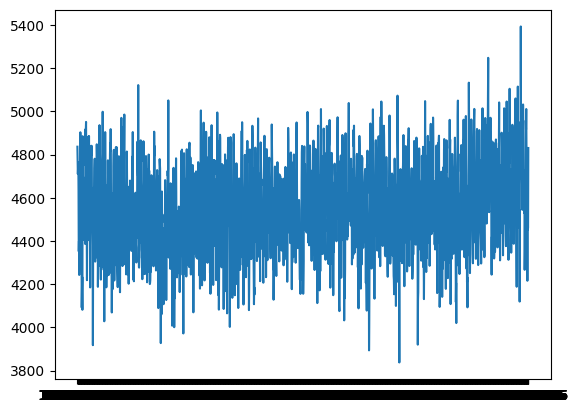

In [11]:
air1d = da.isel(lon=0, lat=0)
plt.plot(air1d.time,air1d.__xarray_dataarray_variable__)

## Model 2

In [12]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/access-esm1-5/hist-2-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [13]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_2.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [14]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [15]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [16]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [17]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [18]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4770.9463, 4754.896 , 4739.0444, ..., 4988.5664, 4988.5664,
         5037.8555],
        [4806.781 , 4792.6514, 4779.083 , ..., 5047.862 , 5047.862 ,
         5089.628 ],
        [4840.0063, 4828.5713, 4816.4976, ..., 5089.3105, 5089.3105,
         5126.5947],
        ...,
        [5228.295 , 5237.4004, 5243.6143, ..., 5186.441 , 5186.441 ,
         5192.234 ],
        [5189.359 , 5199.4697, 5206.0796, ..., 5212.324 , 5212.324 ,
         5214.952 ],
        [5150.9595, 5164.8877, 5176.743 , ..., 5234.063 , 5234.063 ,
         5233.5244]],

       [[4951.6895, 4959.739 , 4960.843 , ..., 5250.7085, 5250.7085,
         5323.915 ],
        [4993.5327, 5004.439 , 5009.1606, ..., 5307.107 , 5307.107 ,
         5372.784 ],
        [5030.508 , 5044.6245, 5053.984 , ..., 5353.612 , 5353.612 ,
         5409.097 ],
...
        [5438.5576, 5441.712 , 5442.4297, ..., 5381.3413, 5381.3413,
         5369.9385],
        [5420.302 , 5419.3003, 5418.171 , ..., 5370.832 , 5370.832 ,
         5368.1655],
        [5390.2627, 5386.655 , 5385.844 , ..., 5368.326 , 5368.326 ,
         5374.5586]],

       [[5057.742 , 5076.8784, 5090.947 , ..., 5186.484 , 5186.484 ,
         5220.503 ],
        [5191.9736, 5203.5034, 5210.88  , ..., 5284.5522, 5284.5522,
         5314.917 ],
        [5294.897 , 5302.4995, 5305.5503, ..., 5353.4946, 5353.4946,
         5380.8745],
        ...,
        [5496.017 , 5484.7583, 5472.0938, ..., 5415.8315, 5415.8315,
         5420.5293],
        [5456.382 , 5441.1816, 5428.552 , ..., 5426.8667, 5426.8667,
         5434.124 ],
        [5408.21  , 5395.3755, 5385.694 , ..., 5437.013 , 5437.013 ,
         5445.954 ]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [19]:
flh.to_netcdf(filepath)

## Model 3

In [20]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/awi-cm-1-1-mr/hist-3-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [21]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_3.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [22]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [23]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [24]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [25]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [26]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4763.877 , 4774.2485, 4776.4673, ..., 4773.93  , 4782.211 ,
         4792.7554],
        [4802.1567, 4809.668 , 4809.8403, ..., 4840.1704, 4852.2266,
         4863.7407],
        [4828.3384, 4834.489 , 4835.6533, ..., 4898.004 , 4910.6445,
         4923.2036],
        ...,
        [5034.4854, 5045.4214, 5057.9307, ..., 4972.89  , 4966.1914,
         4973.895 ],
        [5013.699 , 5026.4937, 5042.5337, ..., 4989.924 , 4979.024 ,
         4980.839 ],
        [4990.0557, 4998.584 , 5014.0996, ..., 5009.012 , 5000.3145,
         4997.5215]],

       [[4815.239 , 4811.7915, 4801.199 , ..., 4815.802 , 4810.5317,
         4799.6836],
        [4856.5967, 4854.499 , 4844.6343, ..., 4839.9927, 4840.2505,
         4837.9775],
        [4895.832 , 4895.7666, 4887.4053, ..., 4856.331 , 4862.847 ,
         4869.685 ],
...
        [5169.447 , 5166.6865, 5164.0435, ..., 5161.187 , 5151.879 ,
         5146.8696],
        [5144.4663, 5142.7812, 5141.6914, ..., 5130.0337, 5123.1255,
         5122.5107],
        [5109.553 , 5109.2173, 5108.713 , ..., 5102.3545, 5100.7217,
         5100.262 ]],

       [[4960.9253, 4964.1006, 4967.0557, ..., 4892.283 , 4898.3047,
         4901.9565],
        [4977.2793, 4980.703 , 4983.618 , ..., 4944.291 , 4947.735 ,
         4951.723 ],
        [4991.738 , 4996.24  , 4999.609 , ..., 4995.3115, 4996.449 ,
         5001.264 ],
        ...,
        [5116.841 , 5111.9087, 5106.7207, ..., 4997.9487, 4989.2227,
         4985.4287],
        [5096.0234, 5088.3516, 5080.9644, ..., 4982.598 , 4976.4565,
         4967.24  ],
        [5063.282 , 5050.9775, 5042.215 , ..., 4972.8315, 4972.486 ,
         4962.538 ]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [27]:
flh.to_netcdf(filepath)

## Model 4

In [28]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/bcc-csm2-mr/hist-4-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [29]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_4.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [30]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [31]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [32]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [33]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [34]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4598.769 , 4608.3076, 4615.4365, ..., 4762.5005, 4784.127 ,
         4807.608 ],
        [4637.37  , 4646.058 , 4654.4854, ..., 4809.0923, 4829.587 ,
         4850.786 ],
        [4674.5215, 4682.2485, 4691.051 , ..., 4849.4155, 4869.686 ,
         4889.298 ],
        ...,
        [4960.5864, 4957.6504, 4959.7266, ..., 4989.106 , 4986.6724,
         4985.0615],
        [4933.804 , 4934.2275, 4939.468 , ..., 4977.519 , 4977.3604,
         4977.7217],
        [4933.804 , 4934.2275, 4939.468 , ..., 4977.519 , 4977.3604,
         4977.7217]],

       [[4839.003 , 4848.718 , 4850.6343, ..., 5031.392 , 5032.5317,
         5036.6875],
        [4870.0894, 4876.925 , 4876.951 , ..., 5065.7095, 5072.1865,
         5078.5703],
        [4891.6924, 4896.267 , 4896.6655, ..., 5090.606 , 5101.048 ,
         5107.6646],
...
        [5103.457 , 5103.1753, 5106.524 , ..., 5064.9   , 5059.5586,
         5064.2188],
        [5069.3364, 5067.9673, 5069.0645, ..., 5042.7993, 5030.187 ,
         5036.079 ],
        [5069.3364, 5067.9673, 5069.0645, ..., 5042.7993, 5030.187 ,
         5036.079 ]],

       [[4768.3335, 4782.65  , 4793.38  , ..., 5146.1455, 5165.0205,
         5183.152 ],
        [4783.1406, 4803.07  , 4819.4873, ..., 5177.4814, 5196.652 ,
         5212.8047],
        [4787.6978, 4813.098 , 4835.9785, ..., 5195.876 , 5214.758 ,
         5228.8228],
        ...,
        [4912.246 , 4890.6797, 4881.051 , ..., 5039.9097, 5044.2925,
         5046.2427],
        [4864.7207, 4843.5913, 4832.257 , ..., 5018.611 , 5024.6455,
         5028.552 ],
        [4864.7207, 4843.5913, 4832.257 , ..., 5018.611 , 5024.6455,
         5028.552 ]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [35]:
flh.to_netcdf(filepath)

## Model 5

In [36]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/cams-csm1-0/hist-5-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [37]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_5.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [38]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [39]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [40]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [41]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [42]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4612.862 , 4627.79  , 4656.1387, ..., 4892.6973, 4897.563 ,
         4908.438 ],
        [4667.9673, 4683.722 , 4712.9023, ..., 4939.592 , 4945.347 ,
         4960.1113],
        [4722.4746, 4742.8657, 4768.861 , ..., 4972.524 , 4981.215 ,
         4995.478 ],
        ...,
        [4921.3027, 4917.0156, 4911.3857, ..., 4846.779 , 4843.709 ,
         4854.9824],
        [4883.295 , 4881.1797, 4875.3477, ..., 4844.3286, 4840.048 ,
         4842.051 ],
        [4883.295 , 4881.1797, 4875.3477, ..., 4844.3286, 4840.048 ,
         4842.051 ]],

       [[4865.4375, 4924.351 , 4971.298 , ..., 5247.243 , 5255.4707,
         5269.794 ],
        [4933.9355, 4974.1865, 5007.1445, ..., 5267.059 , 5276.168 ,
         5288.897 ],
        [4972.1045, 4999.5713, 5025.9565, ..., 5278.7915, 5283.807 ,
         5287.802 ],
...
        [5165.306 , 5155.651 , 5152.028 , ..., 5088.8096, 5092.7017,
         5097.311 ],
        [5137.1064, 5132.2715, 5129.099 , ..., 5086.7637, 5085.208 ,
         5079.5215],
        [5137.1064, 5132.2715, 5129.099 , ..., 5086.7637, 5085.208 ,
         5079.5215]],

       [[4874.8164, 4910.0444, 4946.665 , ..., 5012.45  , 5026.28  ,
         5045.1655],
        [4964.735 , 4993.137 , 5021.2803, ..., 5058.619 , 5069.549 ,
         5086.885 ],
        [5037.101 , 5063.05  , 5088.763 , ..., 5095.88  , 5104.044 ,
         5115.359 ],
        ...,
        [5330.1006, 5327.7446, 5326.8447, ..., 5173.622 , 5153.8687,
         5155.2734],
        [5270.793 , 5267.2324, 5258.644 , ..., 5155.3525, 5133.2393,
         5124.026 ],
        [5270.793 , 5267.2324, 5258.644 , ..., 5155.3525, 5133.2393,
         5124.026 ]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [43]:
flh.to_netcdf(filepath)

## Model 6

In [44]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/canesm5/hist-6-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [45]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_6.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [46]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [47]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [48]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [49]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [50]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4414.377 , 4477.6655, 4477.6655, ..., 5097.752 , 5097.752 ,
         5097.752 ],
        [4621.2104, 4688.208 , 4688.208 , ..., 5142.775 , 5142.775 ,
         5142.775 ],
        [4621.2104, 4688.208 , 4688.208 , ..., 5142.775 , 5142.775 ,
         5142.775 ],
        ...,
        [4975.518 , 4980.094 , 4980.094 , ..., 4929.8833, 4929.8833,
         4929.8833],
        [4975.518 , 4980.094 , 4980.094 , ..., 4929.8833, 4929.8833,
         4929.8833],
        [4975.518 , 4980.094 , 4980.094 , ..., 4929.8833, 4929.8833,
         4929.8833]],

       [[4407.404 , 4496.7095, 4496.7095, ..., 5023.535 , 5023.535 ,
         5023.535 ],
        [4549.85  , 4617.8174, 4617.8174, ..., 5109.702 , 5109.702 ,
         5109.702 ],
        [4549.85  , 4617.8174, 4617.8174, ..., 5109.702 , 5109.702 ,
         5109.702 ],
...
        [5348.4893, 5329.352 , 5329.352 , ..., 5317.3115, 5317.3115,
         5317.3115],
        [5348.4893, 5329.352 , 5329.352 , ..., 5317.3115, 5317.3115,
         5317.3115],
        [5348.4893, 5329.352 , 5329.352 , ..., 5317.3115, 5317.3115,
         5317.3115]],

       [[4613.4326, 4659.6064, 4659.6064, ..., 5209.218 , 5209.218 ,
         5209.218 ],
        [4913.2695, 4946.0327, 4946.0327, ..., 5355.631 , 5355.631 ,
         5355.631 ],
        [4913.2695, 4946.0327, 4946.0327, ..., 5355.631 , 5355.631 ,
         5355.631 ],
        ...,
        [5255.4517, 5286.557 , 5286.557 , ..., 5296.6084, 5296.6084,
         5296.6084],
        [5255.4517, 5286.557 , 5286.557 , ..., 5296.6084, 5296.6084,
         5296.6084],
        [5255.4517, 5286.557 , 5286.557 , ..., 5296.6084, 5296.6084,
         5296.6084]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [51]:
flh.to_netcdf(filepath)

## Model 7

In [52]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/canesm5-canoe/hist-7-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [53]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_7.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [54]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [55]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [56]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [57]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [58]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4427.104 , 4468.2905, 4468.2905, ..., 4882.4214, 4882.4214,
         4882.4214],
        [4543.562 , 4573.898 , 4573.898 , ..., 4965.1284, 4965.1284,
         4965.1284],
        [4543.562 , 4573.898 , 4573.898 , ..., 4965.1284, 4965.1284,
         4965.1284],
        ...,
        [4659.05  , 4652.5806, 4652.5806, ..., 4626.6587, 4626.6587,
         4626.6587],
        [4659.05  , 4652.5806, 4652.5806, ..., 4626.6587, 4626.6587,
         4626.6587],
        [4659.05  , 4652.5806, 4652.5806, ..., 4626.6587, 4626.6587,
         4626.6587]],

       [[4626.7285, 4682.723 , 4682.723 , ..., 5040.044 , 5040.044 ,
         5040.044 ],
        [4747.547 , 4805.2256, 4805.2256, ..., 5070.3276, 5070.3276,
         5070.3276],
        [4747.547 , 4805.2256, 4805.2256, ..., 5070.3276, 5070.3276,
         5070.3276],
...
        [5335.83  , 5332.5254, 5332.5254, ..., 5331.68  , 5331.68  ,
         5331.68  ],
        [5335.83  , 5332.5254, 5332.5254, ..., 5331.68  , 5331.68  ,
         5331.68  ],
        [5335.83  , 5332.5254, 5332.5254, ..., 5331.68  , 5331.68  ,
         5331.68  ]],

       [[4843.021 , 4832.889 , 4832.889 , ..., 4804.0737, 4804.0737,
         4804.0737],
        [4970.41  , 4967.199 , 4967.199 , ..., 4915.369 , 4915.369 ,
         4915.369 ],
        [4970.41  , 4967.199 , 4967.199 , ..., 4915.369 , 4915.369 ,
         4915.369 ],
        ...,
        [5318.706 , 5328.1626, 5328.1626, ..., 5289.236 , 5289.236 ,
         5289.236 ],
        [5318.706 , 5328.1626, 5328.1626, ..., 5289.236 , 5289.236 ,
         5289.236 ],
        [5318.706 , 5328.1626, 5328.1626, ..., 5289.236 , 5289.236 ,
         5289.236 ]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [59]:
flh.to_netcdf(filepath)

## Model 8

In [60]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/cesm2/hist-8-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [61]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_8.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [62]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [63]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [64]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [65]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [66]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4644.707 , 4643.8926, 4642.814 , ..., 4814.428 , 4859.3115,
         4904.8525],
        [4706.3745, 4704.6484, 4700.4785, ..., 4868.6416, 4917.0073,
         4966.6553],
        [4763.7534, 4757.483 , 4749.455 , ..., 4921.9473, 4972.129 ,
         5017.533 ],
        ...,
        [4968.8003, 4961.8784, 4959.7554, ..., 5010.9688, 5010.4785,
         5011.1533],
        [4953.1597, 4947.8203, 4948.2617, ..., 5005.907 , 5006.8975,
         5004.179 ],
        [4925.1807, 4919.5137, 4918.4585, ..., 5020.3315, 5018.0537,
         5009.0874]],

       [[4643.9214, 4644.693 , 4653.4043, ..., 4998.1943, 5005.638 ,
         5013.3706],
        [4706.588 , 4707.872 , 4708.5376, ..., 5034.7944, 5041.2954,
         5049.878 ],
        [4753.925 , 4757.4697, 4762.814 , ..., 5076.2285, 5082.0513,
         5086.488 ],
...
        [5238.359 , 5240.617 , 5241.0947, ..., 5118.554 , 5110.9224,
         5106.944 ],
        [5218.2593, 5219.747 , 5220.0024, ..., 5098.1064, 5096.4414,
         5092.7764],
        [5185.944 , 5188.1143, 5188.1167, ..., 5072.086 , 5069.7046,
         5064.9688]],

       [[4443.2256, 4431.161 , 4429.8604, ..., 4775.612 , 4800.9663,
         4827.143 ],
        [4491.671 , 4490.6025, 4489.4126, ..., 4811.808 , 4835.859 ,
         4860.5396],
        [4542.3877, 4544.6924, 4540.345 , ..., 4837.642 , 4861.456 ,
         4885.6045],
        ...,
        [5000.2944, 5001.1733, 5001.9653, ..., 4929.332 , 4920.8047,
         4914.727 ],
        [4976.6406, 4974.3345, 4973.943 , ..., 4912.35  , 4900.7983,
         4895.0312],
        [4941.713 , 4941.382 , 4940.0454, ..., 4883.2925, 4882.527 ,
         4879.2163]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-15' '1850-02-14' ... '2014-12-15'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [67]:
flh.to_netcdf(filepath)

## Model 9

In [68]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/cesm2-waccm/hist-9-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [69]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_9.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [70]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [71]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [72]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [74]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [75]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4309.024 , 4330.2563, 4355.3955, ..., 4685.5723, 4700.985 ,
         4717.068 ],
        [4351.403 , 4373.0063, 4401.4297, ..., 4748.2876, 4767.1465,
         4784.1147],
        [4390.2563, 4413.536 , 4436.8496, ..., 4806.141 , 4823.2476,
         4840.746 ],
        ...,
        [4867.039 , 4867.3203, 4871.3213, ..., 4877.8057, 4868.7925,
         4860.2227],
        [4808.724 , 4813.5713, 4820.9434, ..., 4864.391 , 4862.688 ,
         4853.8496],
        [4781.2095, 4787.178 , 4791.2896, ..., 4872.62  , 4869.1377,
         4863.413 ]],

       [[4569.2524, 4580.4893, 4591.7896, ..., 4914.577 , 4939.866 ,
         4957.446 ],
        [4622.179 , 4635.5674, 4644.82  , ..., 4944.5703, 4961.8657,
         4977.3374],
        [4671.622 , 4681.2793, 4689.257 , ..., 4960.719 , 4973.6445,
         4991.7134],
...
        [5146.746 , 5146.7783, 5144.612 , ..., 5096.284 , 5092.8374,
         5092.828 ],
        [5137.6733, 5140.8896, 5138.0396, ..., 5079.6025, 5078.054 ,
         5076.6616],
        [5106.3047, 5110.981 , 5111.9297, ..., 5059.334 , 5056.925 ,
         5054.157 ]],

       [[4590.562 , 4593.1245, 4599.197 , ..., 4962.83  , 4980.758 ,
         4998.6377],
        [4655.9067, 4659.2207, 4664.28  , ..., 5011.458 , 5028.855 ,
         5042.5073],
        [4712.5405, 4714.9062, 4718.943 , ..., 5050.8413, 5062.15  ,
         5072.546 ],
        ...,
        [5156.4863, 5152.0845, 5152.072 , ..., 5109.004 , 5099.534 ,
         5092.17  ],
        [5113.5474, 5110.096 , 5107.3306, ..., 5089.149 , 5086.6357,
         5084.0664],
        [5068.038 , 5063.904 , 5060.331 , ..., 5065.605 , 5065.99  ,
         5066.2534]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-15' '1850-02-14' ... '2014-12-15'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [76]:
flh.to_netcdf(filepath)

## Model 10

In [77]:
ds = xr.open_dataset('/network/rit/lab/vuillelab_rit/sturner/data/model/cmip6/hist/cmcc-cm2-sr5/hist-10-both.nc')
import datetime as dt
ds['time'] = ds["time"].dt.strftime("%Y-%m-%d")

In [78]:
def grad(t1,t2,x):   
    y = (t1-x) / (t1-t2)
    return y
def height(z1,z2,y):
    zf = z1 + (y*(z2-z1))
    return zf

filepath = Path('/network/rit/lab/vuillelab_rit/sturner/output/flh/spatiotemporal/cmip6/hist/flh_10.nc')  
filepath.parent.mkdir(parents=True, exist_ok=True) 

In [79]:
ds_400_500=ds.where((ds.ta[:,2,:,:] <273.15)&(ds.ta[:,1,:,:] >273.15))
ds_500_600=ds.where((ds.ta[:,1,:,:] <273.15)&(ds.ta[:,0,:,:] >273.15))
ds_up=ds.where((ds.ta[:,2,:,:] >273.15))
ds_down=ds.where((ds.ta[:,0,:,:] <273.15))

In [80]:
y_400 = grad(ds_400_500.ta[:,1,:,:],ds_400_500.ta[:,2,:,:],273.15)
flh_400 = height(ds_400_500.zg[:,1,:,:],ds_400_500.zg[:,2,:,:],y_400)

In [81]:
y_500 = grad(ds_500_600.ta[:,0,:,:],ds_500_600.ta[:,1,:,:],273.15)
flh_500 = height(ds_500_600.zg[:,0,:,:],ds_500_600.zg[:,1,:,:],y_500)

In [82]:
y_up = grad(ds_up.ta[:,1,:,:],ds_up.ta[:,2,:,:],273.15)
flh_up = height(ds_up.zg[:,1,:,:],ds_up.zg[:,2,:,:],y_up)
y_down = grad(ds_down.ta[:,0,:,:],ds_down.ta[:,1,:,:],273.15) 
flh_down = height(ds_down.zg[:,0,:,:],ds_down.zg[:,1,:,:],y_down)

In [83]:
flh=flh_400.fillna(0)+flh_500.fillna(0)+flh_down.fillna(0)+flh_up.fillna(0)
flh=flh.where(flh != 0)
flh

<xarray.DataArray (time: 1980, lat: 27, lon: 26)>
array([[[4716.245 , 4743.914 , 4773.993 , ..., 5193.184 , 5210.863 ,
         5228.13  ],
        [4728.2246, 4751.869 , 4780.825 , ..., 5214.609 , 5230.916 ,
         5244.0386],
        [4733.296 , 4754.003 , 4780.684 , ..., 5228.3413, 5239.9126,
         5247.363 ],
        ...,
        [4807.1177, 4824.878 , 4844.995 , ..., 4902.301 , 4897.2246,
         4890.8135],
        [4766.2534, 4781.8496, 4802.7593, ..., 4911.967 , 4912.725 ,
         4908.105 ],
        [4726.9653, 4746.5366, 4774.8145, ..., 4906.022 , 4903.9355,
         4899.994 ]],

       [[4943.864 , 4953.091 , 4964.2876, ..., 5244.6504, 5256.1104,
         5267.9434],
        [4954.536 , 4963.0156, 4974.2593, ..., 5257.5586, 5266.9546,
         5275.726 ],
        [4955.2246, 4962.655 , 4973.1997, ..., 5260.8374, 5267.9746,
         5274.234 ],
...
        [5061.6113, 5060.962 , 5061.3984, ..., 5052.463 , 5044.603 ,
         5037.6636],
        [5047.0234, 5047.8154, 5045.486 , ..., 5037.449 , 5033.494 ,
         5024.788 ],
        [5039.116 , 5041.1094, 5040.804 , ..., 5028.9487, 5029.5454,
         5022.8774]],

       [[4936.3867, 4961.7944, 4978.21  , ..., 5051.262 , 5056.0947,
         5061.404 ],
        [4967.2695, 4989.989 , 5000.767 , ..., 5069.3335, 5076.829 ,
         5084.9805],
        [4994.5977, 5010.2935, 5017.789 , ..., 5086.8687, 5095.184 ,
         5100.1357],
        ...,
        [5220.2114, 5219.4614, 5228.6064, ..., 5076.766 , 5062.704 ,
         5047.457 ],
        [5203.814 , 5205.778 , 5214.462 , ..., 5072.936 , 5055.2563,
         5037.4033],
        [5186.509 , 5188.86  , 5191.5605, ..., 5072.6313, 5063.8555,
         5054.0913]]], dtype=float32)
Coordinates:
  * time     (time) object '1850-01-16' '1850-02-15' ... '2014-12-16'
  * lon      (lon) float64 240.0 241.0 242.0 243.0 ... 262.0 263.0 264.0 265.0
  * lat      (lat) float64 -20.5 -19.5 -18.5 -17.5 -16.5 ... 1.5 2.5 3.5 4.5 5.5

In [84]:
flh.to_netcdf(filepath)